In [1]:
#python libraries
import os
import re
import copy

#other ML libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#ploting
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Setting random seeds for reproducibility
random_seed = 420
np.random.seed(random_seed)
_ = torch.manual_seed(random_seed)

### DATA CLEANING

In [3]:
#Import Disruptive & Netatmo Sensor Data

# assign variables
directory = './storedData/'
sensor_data = pd.DataFrame()
sensor_data['timestamp'] = None #in order to merge based on it 

measurement_types = ["Door", "Water", "Humidity_temperature", "Humidity_humidity", 
                     "Humidifier_humidity", "Humidifier_temperature","Temperature",
                     "Hum_temperature", "Hum_humidity"]
discrete_measurement_types = ["Door", "Water"]


# iterate over files in that directory and concat into 1 big dataframe based on timestamps
for filename in os.listdir(directory): 
    file = os.path.join(directory, filename)
    if os.path.isfile(file):    
        df = pd.read_csv(file)
        df.drop(columns=df.columns[0], inplace=True) # dropping unnamed coloumn for indexing in .cvs file

        df['timestamp'] = pd.to_datetime(df['timestamp'],  utc=True)#.dt.tz_convert('Europe/Rome') #set timezone correctly if not correct in local time
        df.set_index("timestamp", inplace=True)
        for measurement_name in df.columns:
            measurement_frame = df[measurement_name].to_frame()

            measurement_name_list = re.findall("([A-Z0-9][^A-Z]*)", measurement_name) # Splitting string on capital letters
            measurement_type = measurement_name_list[-1]
            if measurement_type not in measurement_types: #Temperature measurements does not have temperature in their name
                measurement_type = "Temperature"
                measurement_name_list.append(measurement_type)
            #Renaming coloumn for consistent naming
            coloumn_name = f"{''.join(measurement_name_list[:-1])}_{measurement_type.lower()}"
            measurement_frame.rename(columns={measurement_frame.columns[0]: coloumn_name}, inplace=True)
            # print(f"key: {measurement_frame.columns[0]} Value: {coloumn_name}")
            if measurement_type in discrete_measurement_types:
                #For Water Detection:
                #NOT_PRESENT == No water detected = 0
                #PRESENT     == water detected    = 1

                #For Door Sensors: - this is because sensor changes state based on if it detects objects in front of it
                #NOT_PRESENT == DOOR IS OPEN     = 0
                #PRESENT     == DOOR IS CLOSED   = 1
                
                measurement_frame.replace(['NOT_PRESENT', 'PRESENT'],[0, 1], inplace=True)
                measurement_frame = measurement_frame.resample('15T').ffill()
            else: #Contious measurement
                measurement_frame  = measurement_frame.resample('15T').mean().interpolate() #Resample to managable timestamps by taking mean of 5 minute slots and linear interpolating NaNs, i.e. 5, 10, 15, 20 minutes etc..

    
            sensor_data = pd.merge(sensor_data, measurement_frame, on='timestamp', how="outer")  

sensor_data.set_index("timestamp", inplace=True)
sensor_data.sort_index(axis=0, inplace=True) #Sorting by timestamp
sensor_data.sort_index(axis=1, inplace=True) #Sorting columns alpabetically

#Postprocesing the data in order to get rid of the NaN Values
#ffill and fillna(0/1) to populate NaN values of the proximity with ffill and then set the values before first valid value to DOOR_CLOSED/NO_WATER
sensor_data.loc[:, sensor_data.columns.str.endswith('door')] = sensor_data.loc[:, sensor_data.columns.str.endswith('door')].ffill().fillna(1)
sensor_data.loc[:, sensor_data.columns.str.endswith('water')] = sensor_data.loc[:, sensor_data.columns.str.endswith('water')].ffill().fillna(0)


# # #linearly interpolate temperature and humidity values:
sensor_data.loc[:, sensor_data.columns.str.endswith('temperature')]  = sensor_data.loc[:, sensor_data.columns.str.endswith('temperature')].interpolate().bfill().ffill()
sensor_data.loc[:, sensor_data.columns.str.endswith('humidity')]  = sensor_data.loc[:, sensor_data.columns.str.endswith('humidity')].interpolate().bfill().ffill()

### EXPLORATORY DATA ANALYSIS ###

<AxesSubplot: xlabel='timestamp'>

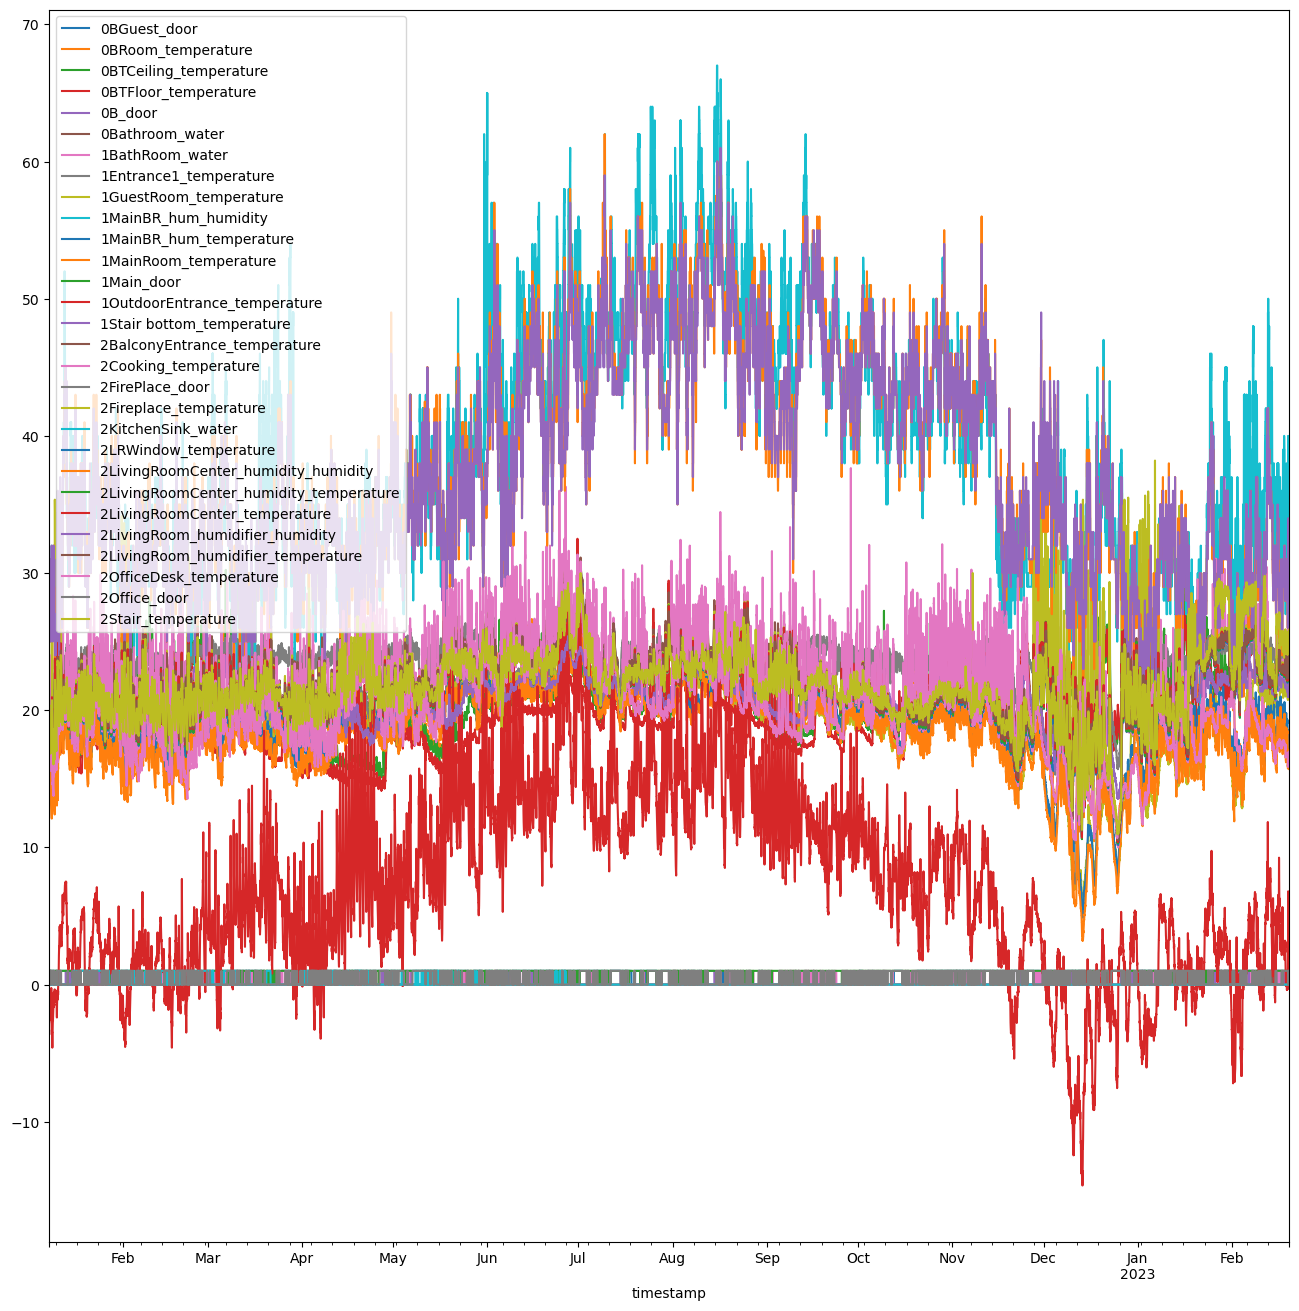

In [4]:
#plot the data
sensor_data.plot(figsize=(16, 16))

### FEATURE ENGINEERING ###

In [5]:
#Add hand-designed time-of-day and day-of-year features
min_in_hour = 60
min_in_day = 24*min_in_hour
sensor_data['sin_daily'] = np.sin(2*np.pi*(sensor_data.index.minute + sensor_data.index.hour*min_in_hour)/min_in_day).values
sensor_data['cos_daily'] = np.cos(2*np.pi*(sensor_data.index.minute + sensor_data.index.hour*min_in_hour)/min_in_day).values

days_in_year = 365.2425
sensor_data['sin_yearly'] = np.sin(2*np.pi*(sensor_data.index.day_of_year)/days_in_year).values
sensor_data['cos_yearly'] = np.cos(2*np.pi*(sensor_data.index.day_of_year)/days_in_year).values

days_in_week = 7
sensor_data['sin_weekly'] = np.sin(2*np.pi*(sensor_data.index.day_of_week)/days_in_week).values
sensor_data['cos_weekly'] = np.cos(2*np.pi*(sensor_data.index.day_of_week)/days_in_week).values

In [6]:
sensor_data.describe()

,0BGuest_door,0BRoom_temperature,0BTCeiling_temperature,0BTFloor_temperature,0B_door,0Bathroom_water,1BathRoom_water,1Entrance1_temperature,1GuestRoom_temperature,1MainBR_hum_humidity,...,2LivingRoom_humidifier_temperature,2OfficeDesk_temperature,2Office_door,2Stair_temperature,sin_daily,cos_daily,sin_yearly,cos_yearly,sin_weekly,cos_weekly
count,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,...,39166.000000,39166.000000,39166.000000,39166.000000,3.916600e+04,3.916600e+04,39166.000000,39166.000000,39166.000000,39166.000000
mean,0.731093,20.219920,20.493444,19.880145,0.159577,0.003396,0.113925,23.061776,18.888458,38.371860,...,21.596080,20.351772,0.398739,21.664779,4.776617e-05,-1.797791e-05,0.048966,0.089977,-0.004115,0.000289
std,0.443397,2.777353,2.358416,2.570392,0.366218,0.058175,0.317725,1.703731,3.133083,9.052182,...,2.549447,3.360557,0.489645,2.543805,7.071023e-01,7.071294e-01,0.686751,0.719656,0.707943,0.706275
min,0.000000,10.250000,15.100000,14.150000,0.000000,0.000000,0.000000,15.300000,5.700000,19.000000,...,10.550000,10.525000,0.000000,10.950000,-1.000000e+00,-1.000000e+00,-0.999999,-0.999979,-0.974928,-0.900969
25%,0.000000,18.800000,18.750000,18.050000,0.000000,0.000000,0.000000,22.300000,17.650000,31.000000,...,20.100000,18.383333,0.000000,20.250000,-7.071068e-01,-7.071068e-01,-0.639648,-0.641690,-0.781831,-0.900969
50%,1.000000,20.200000,20.483333,19.750000,0.000000,0.000000,0.000000,23.450000,19.200000,37.000000,...,21.550000,20.200000,0.000000,21.583333,1.224647e-16,-1.836970e-16,0.164758,0.176443,0.000000,-0.222521
75%,1.000000,22.000000,22.100000,21.650000,0.000000,0.000000,0.000000,24.250000,20.925000,45.000000,...,23.300000,22.366667,1.000000,23.116667,7.071068e-01,7.071068e-01,0.681936,0.811856,0.781831,0.623490
max,1.000000,27.450000,31.550000,27.750000,1.000000,1.000000,1.000000,26.900000,28.200000,67.000000,...,30.700000,32.425000,1.000000,30.000000,1.000000e+00,1.000000e+00,0.999986,0.999991,0.974928,1.000000


### DATA PREPROCESSING

In [7]:
train_val_df = sensor_data.iloc[:int(sensor_data.shape[0]*0.9)]
test_df = sensor_data.iloc[int(sensor_data.shape[0]*0.9):]

train_val_split = int(train_val_df.shape[0]*0.8)
train_df = train_val_df[:train_val_split]
val_df = train_val_df[train_val_split:]

train_labels = train_df.loc[:, sensor_data.columns.str.endswith('temperature')].drop("1OutdoorEntrance_temperature", axis=1).sort_index(axis=1)

x_scaler = StandardScaler()
y_scaler = MinMaxScaler()

x_scaler.fit(train_df)
y_scaler.fit(train_labels)

# train_df_norm = scaler.fit_transform(train_df)
# val_df_norm = scaler.transform(val_df)
# test_df_norm = scaler.transform(test_df)


print(f"Shape of train_df = {train_df.shape}, Shape of val_df = {val_df.shape}, Shape of test_df = {test_df.shape}")
print(f"Shape of train_labels = {train_labels.shape}")

Shape of train_df = (28199, 35), Shape of val_df = (7050, 35), Shape of test_df = (3917, 35)
Shape of train_labels = (28199, 17)


In [8]:
import WindowGenerator
import importlib
importlib.reload(WindowGenerator)

measurements_per_day = 4*24
windows = WindowGenerator.WindowGenerator(2*measurements_per_day, measurements_per_day, 0, train_df, val_df, test_df, train_labels.columns)

In [9]:
x_train_norm = []
y_train_norm = []
for inputs, labels in windows.train_data:
    x_train_norm.append(x_scaler.transform(inputs))
    y_train_norm.append(y_scaler.transform(labels))

x_train_norm = np.array(x_train_norm)
x_train_norm = torch.from_numpy(x_train_norm).float()
y_train_norm = np.array(y_train_norm)
y_train_norm = torch.from_numpy(y_train_norm).float()#.reshape(y_train_norm.shape[0], y_train_norm.shape[2])).float()

<AxesSubplot: xlabel='timestamp'>

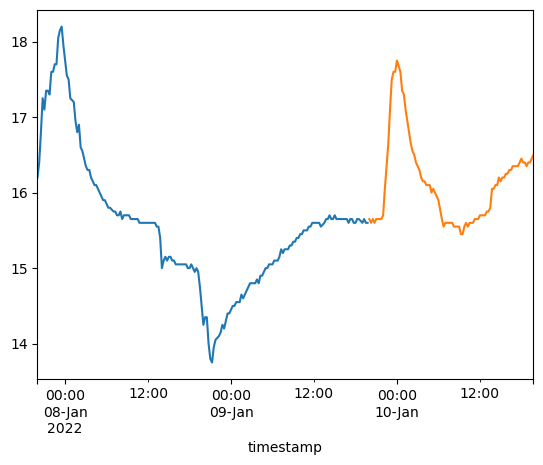

In [10]:
windows.train_data[1][0]['0BRoom_temperature'].plot()
windows.train_data[1][1]['0BRoom_temperature'].plot()

In [11]:
x_val_norm = []
y_val_norm = []
for inputs, labels in windows.val_data:
    x_val_norm.append(x_scaler.transform(inputs))
    y_val_norm.append(y_scaler.transform(labels))

x_val_norm = np.array(x_val_norm)
x_val_norm = torch.from_numpy(x_val_norm).float()
y_val_norm = np.array(y_val_norm)
y_val_norm = torch.from_numpy(y_val_norm).float()#.reshape(y_val_norm.shape[0], y_val_norm.shape[2])).float()

In [12]:
x_test_norm = []
y_test_norm = []
for inputs, labels in windows.test_data:
    x_test_norm.append(x_scaler.transform(inputs))
    y_test_norm.append(y_scaler.transform(labels))

x_test_norm = np.array(x_test_norm)
x_test_norm = torch.from_numpy(x_test_norm).float()
y_test_norm = np.array(y_test_norm)
y_test_norm = torch.from_numpy(y_test_norm).float()#.reshape(y_test_norm.shape[0], y_test_norm.shape[2])).float()

### LSTM

In [13]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_lstm_layers, linear_layers=[]):
        super(Net, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_lstm_layers = num_lstm_layers

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_lstm_layers, batch_first=True)
        if linear_layers == []:
            self.linear_layers = [nn.Linear(hidden_size, output_size)]
        else:
            #He initialization
            first_layer = nn.Linear(hidden_size, linear_layers[0])
            first_layer.weight.data = torch.randn((hidden_size, linear_layers[0]))*np.sqrt(1/hidden_size)
            first_layer.bias.data = torch.zeros(linear_layers[0])
            self.linear_layers = [first_layer]

            for i in range(len(linear_layers)-1):
                n_in = linear_layers[i]
                n_out = linear_layers[i+1]
                layer = torch.nn.Linear(n_in, n_out)

                layer.weight.data = torch.randn((n_out, n_in))*np.sqrt(2/n_in)
                layer.bias.data = torch.zeros(n_out)
                self.linear_layers.append(layer)
            
            last_layer = nn.Linear(linear_layers[-1], output_size)
            last_layer.weight.data = torch.randn((n_out, n_in))*np.sqrt(2/n_in)
            last_layer.bias.data = torch.zeros(n_out)
            self.linear_layers.append(last_layer)

        self.linear_layers = nn.ModuleList(self.linear_layers)
        self.act =nn.ReLU()
        

    def forward(self, input_seq):
        torch.autograd.set_detect_anomaly(True)
        h_0 = Variable(torch.zeros(self.num_lstm_layers, input_seq.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_lstm_layers, input_seq.size(0), self.hidden_size)) #internal state

        output, (hn, cn) = self.lstm(input_seq, (h_0, c_0))
        x = hn.view(-1, self.hidden_size)
        for layer in self.linear_layers:
            x = self.act(x)
            x = layer(x)
        return x

In [14]:
def train(
        net: torch.nn.Module,
        train_data: list,
        val_data: list,
        n_epochs: int,
        lr: float,
        l2_reg: float,
) -> torch.nn.Module:
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr = lr)

    for epoch in range(n_epochs):
        # for inputs, targets in train_data:
        optimizer.zero_grad()
        # net.hidden_cell = (torch.zeros(1, 1, net.hidden_size),
        #                         torch.zeros(1, 1, net.hidden_size))

        outputs = net(train_data[0])
        batch_mse = criterion(outputs, train_data[1])
        reg_loss = 0
        for param in net.parameters():
                reg_loss += param.abs().sum()
        cost = batch_mse + l2_reg * reg_loss
        cost.backward()
        optimizer.step()

        # if epoch % 100 == 0:
        print(f'Epoch: {epoch}, Loss: {cost.item()}')

        # mse_val = 0
        # if epoch % 10 == 0:
        #         for inputs, label in val_data:
        #                 pred = y_scaler.inverse_transform(net(inputs).detach().numpy())
        #                 row_len = len(label[0])
        #                 mse_val += np.sum(np.power(label-pred, 2))
        #         mse_val /= len(val_data)*row_len
        #         print(f'Epoch: {epoch+1}: Val MSE: {mse_val}')
    return net
    

In [15]:
net = Net(input_size=35, hidden_size=128, output_size=17, num_lstm_layers=1)

epochs = 500
lr = 0.01
l2_reg = 1e-9
train(net, [x_train_norm, y_train_norm], [x_val_norm, y_val_norm], epochs, lr, l2_reg)

: 

: 

### EXAMINE MODEL

In [ ]:
# Predict on validation data
pred_val_inv = y_scaler.inverse_transform(net(x_val_norm).detach())
# pred_val = torch.from_numpy(pred_val).to(torch.float)
y_val_inv = y_scaler.inverse_transform(y_val_norm)

# Compute MSE, MAE and MAPE on validation data
print('Error on validation data')

mse_val = np.mean(np.power((pred_val_inv - y_val_inv), 2))
print(f'MSE: {mse_val.item()}')

mae_val = np.mean(np.abs(pred_val_inv - y_val_inv))
print(f'MAE: {mae_val.item()}')

mape_val = 100*np.mean(np.abs(np.divide(pred_val_inv - y_val_inv, y_val_inv)))
print(f'MAPE: {mape_val.item()} %')

Error on validation data
MSE: 0.5314144817190585
MAE: 0.4676609696970215
MAPE: 2.1247229299355466 %


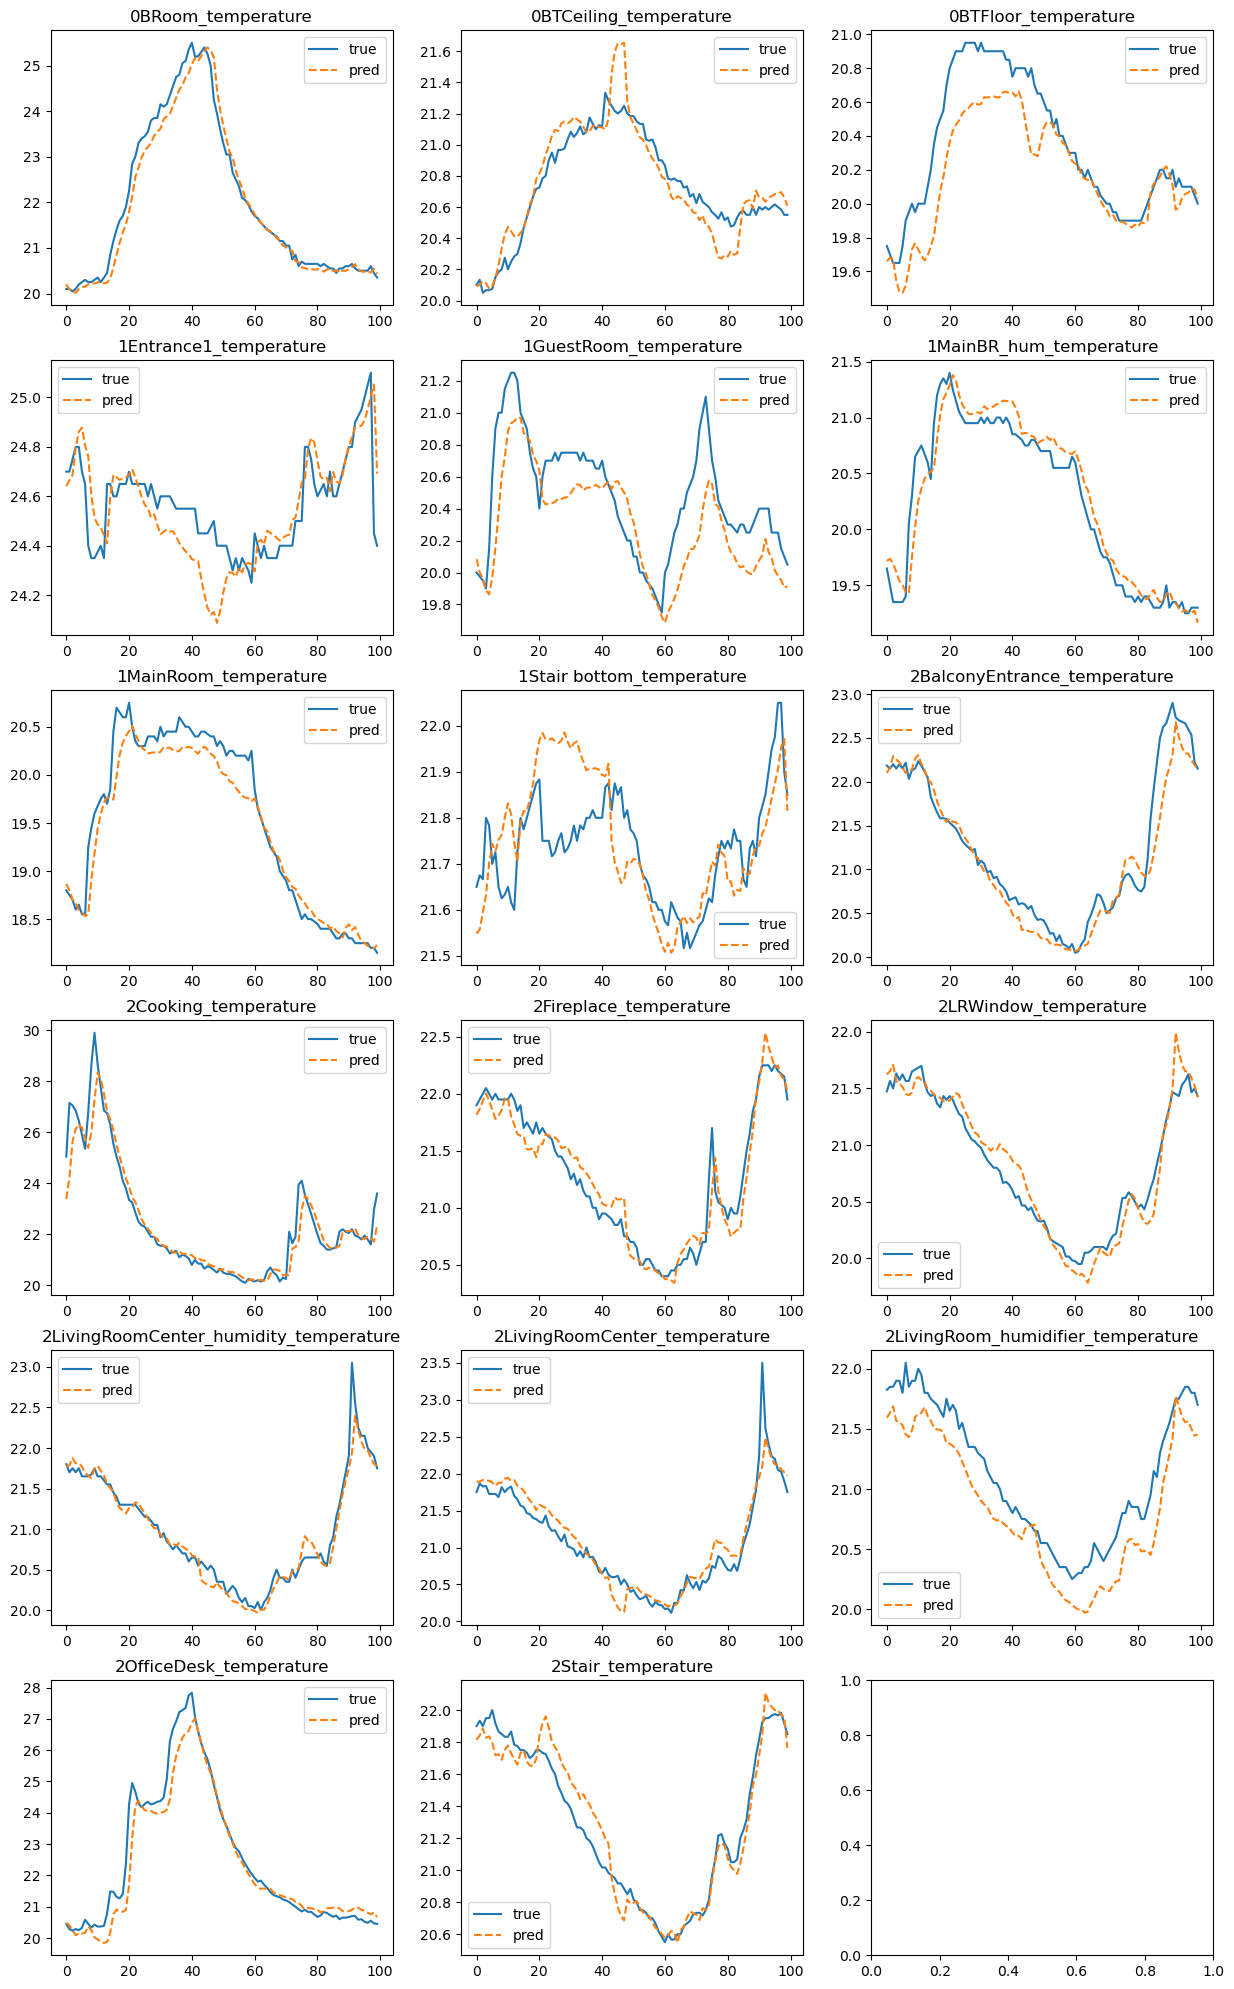

In [ ]:
net.eval()
pred_train = y_scaler.inverse_transform(net(x_val_norm).detach().numpy())
true_train = y_scaler.inverse_transform(y_val_norm.detach().numpy())
net.train()

fig,ax = plt.subplots(6,3,figsize=(15,25))
for i in range(train_labels.shape[1]):
    ax[i//3, i%3].plot(true_train[:100, i], label="true")
    ax[i//3, i%3].plot(pred_train[:100, i], '--', label="pred")
    ax[i//3, i%3].set_title(f"{train_labels.columns[i]}")
    ax[i//3, i%3].legend()

### FORECAST

In [ ]:
current_state = x_val_norm[0].reshape(1, x_val_norm[0].shape[0], x_val_norm[0].shape[1])
current_state.shape

torch.Size([1, 96, 35])

In [ ]:
net(x_test_norm[0].reshape(1, x_test_norm[0].shape[0], x_test_norm[0].shape[1]))


tensor([[0.3045, 0.5239, 0.6454, 0.6022, 0.2411, 0.4151, 0.4130, 0.4187, 0.1983,
         0.1451, 0.1736, 0.2214, 0.2258, 0.2280, 0.2159, 0.2025, 0.2282]],
       grad_fn=<AddmmBackward0>)

### PyTorch Forecasting library